<a href="https://colab.research.google.com/github/Arpanrc901/CAR-RECOMMENDATION-SITE/blob/master/Crime_Pred_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.metrics import r2_score
from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (30,6)
matplotlib.rcParams['axes.titlesize']= 20

In [3]:
def mapperDictGenerator(df, label):
  d= dict()
  factorized= pd.factorize(df[label])
  for i, _ in enumerate(factorized[1]):
    d[i]= _
  return factorized[0], d

In [13]:
df=pd.read_csv('MCI_2014_to_2019.csv')
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,3,2015.0,December,18.0,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,2015,August,17,229,Monday,22,2015.0,August,15.0,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,2015,August,18,230,Tuesday,14,2015.0,August,16.0,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,2015,December,18,352,Friday,13,2015.0,November,26.0,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,19,2015.0,December,18.0,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005


In [14]:
df.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Hood_ID,Long,Lat,ObjectId
count,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206376.000000,206376.000000,206376.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000
mean,-79.394940,43.707379,103218.000000,1696.667755,145.973953,2016.619323,15.746855,187.139933,12.838617,2016.579171,15.511024,186.506653,12.549868,72.230286,-79.394940,43.707379,103218.000000
std,0.104386,0.052718,59592.795747,323.481988,51.739660,1.717764,8.770511,103.601412,6.583508,1.764401,8.904154,103.884073,7.220263,40.758981,0.104386,0.052718,59592.795747
min,-79.639267,43.587093,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,1.000000,-79.639267,43.587093,1.000000
25%,-79.471481,43.661152,51609.500000,1430.000000,100.000000,2015.000000,8.000000,100.000000,8.000000,2015.000000,8.000000,99.000000,7.000000,36.000000,-79.471481,43.661152,51609.500000
50%,-79.393333,43.701328,103218.000000,1450.000000,100.000000,2017.000000,16.000000,189.000000,14.000000,2017.000000,16.000000,188.000000,14.000000,76.000000,-79.393333,43.701328,103218.000000
75%,-79.319374,43.752068,154826.500000,2120.000000,200.000000,2018.000000,23.000000,277.000000,18.000000,2018.000000,23.000000,276.000000,19.000000,108.000000,-79.319374,43.752068,154826.500000
max,-79.123100,43.850788,206435.000000,2135.000000,230.000000,2019.000000,31.000000,366.000000,23.000000,2019.000000,31.000000,366.000000,23.000000,140.000000,-79.123100,43.850788,206435.000000


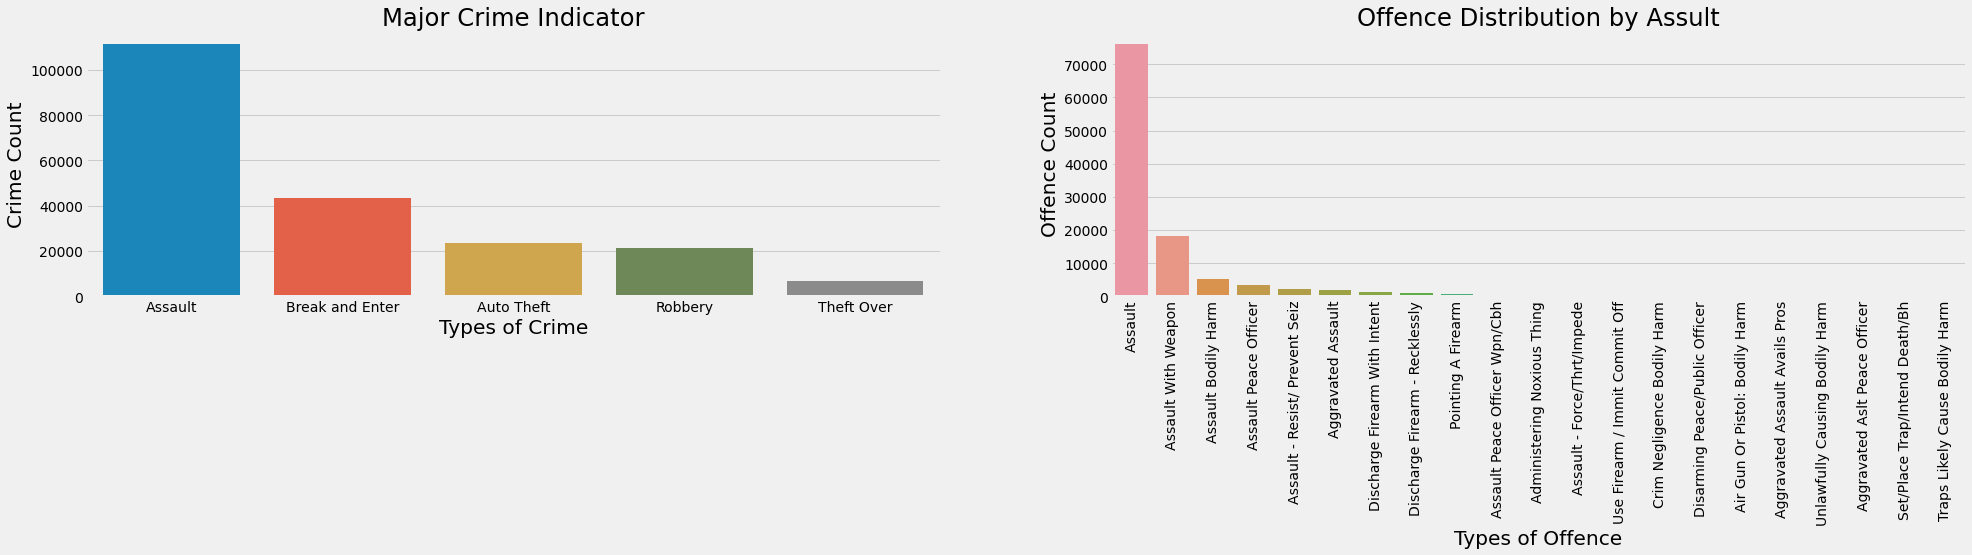

In [15]:
plt.figure(figsize=(30,10))
MCI= df.groupby('MCI',as_index=False).size()
assaultTypes= df[df.MCI=='Assault'].groupby('offence', as_index=False).size()
autoTheftTypes= df[df.MCI=='Auto Theft'].groupby('offence', as_index=False).size()

plt.subplot(221)
sns.barplot(x='MCI', y='size', data=MCI.sort_values(by='size', ascending=False))
plt.title('Major Crime Indicator', fontsize='xx-large')
plt.xlabel('Types of Crime', fontsize='x-large')
plt.ylabel('Crime Count', fontsize='x-large')

plt.subplot(222)
sns.barplot(x='offence', y='size', data=assaultTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Assult', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)



plt.show()

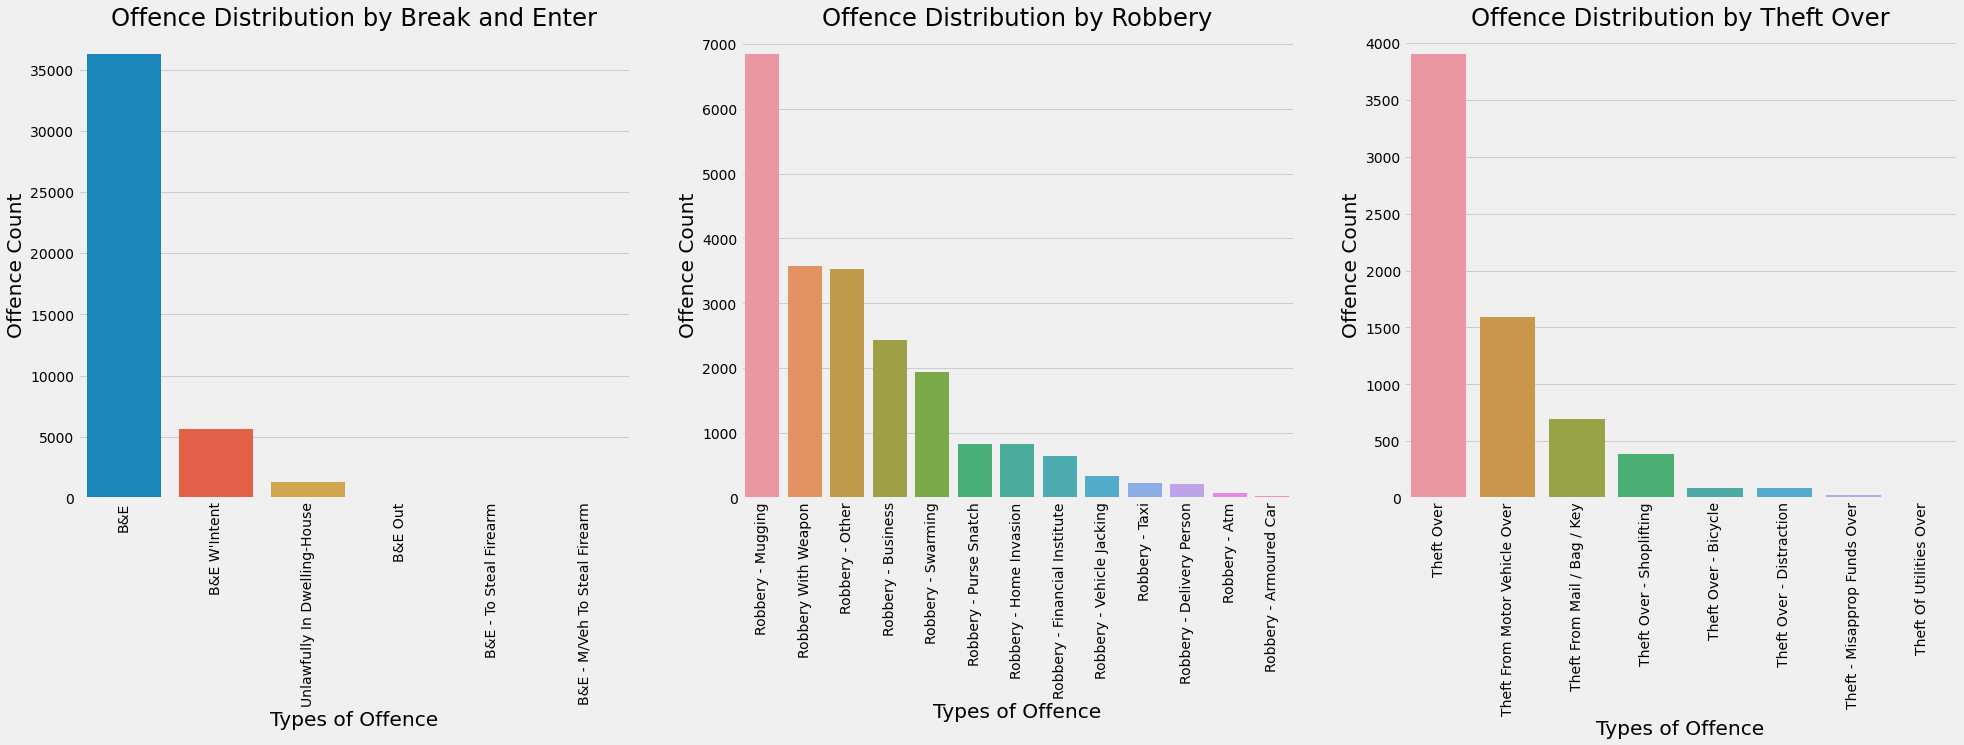

In [16]:
plt.figure(figsize=(30,8))

breakEnterTypes= df[df.MCI=='Break and Enter'].groupby('offence', as_index=False).size()
robberyTypes= df[df.MCI=='Robbery'].groupby('offence', as_index=False).size()
theftOverTypes= df[df.MCI=='Theft Over'].groupby('offence', as_index=False).size()

plt.subplot(131)
sns.barplot(x='offence', y='size', data=breakEnterTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Break and Enter', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(132)
sns.barplot(x='offence', y='size', data=robberyTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Robbery', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(133)
sns.barplot(x='offence', y='size', data=theftOverTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Theft Over', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

In [17]:
df.reporteddate= pd.to_datetime(df.reporteddate)
df['reportOnlyDate']= df.reporteddate.dt.date
df.occurrencedate= pd.to_datetime(df.occurrencedate)
df['occurrenceOnlyDate']= df.occurrencedate.dt.date
df['delayInReporting']= (df.reportOnlyDate - df.occurrenceOnlyDate).dt.days

In [18]:
# **Time Series Forcasting** Problem and Multipath Approach
## Time Series Analysis for **Total Crime Count**

In [19]:
df['count']= 1
mci_monthwise = df.groupby(['occurrenceday','MCI'],as_index=False).agg({'count':'sum'})

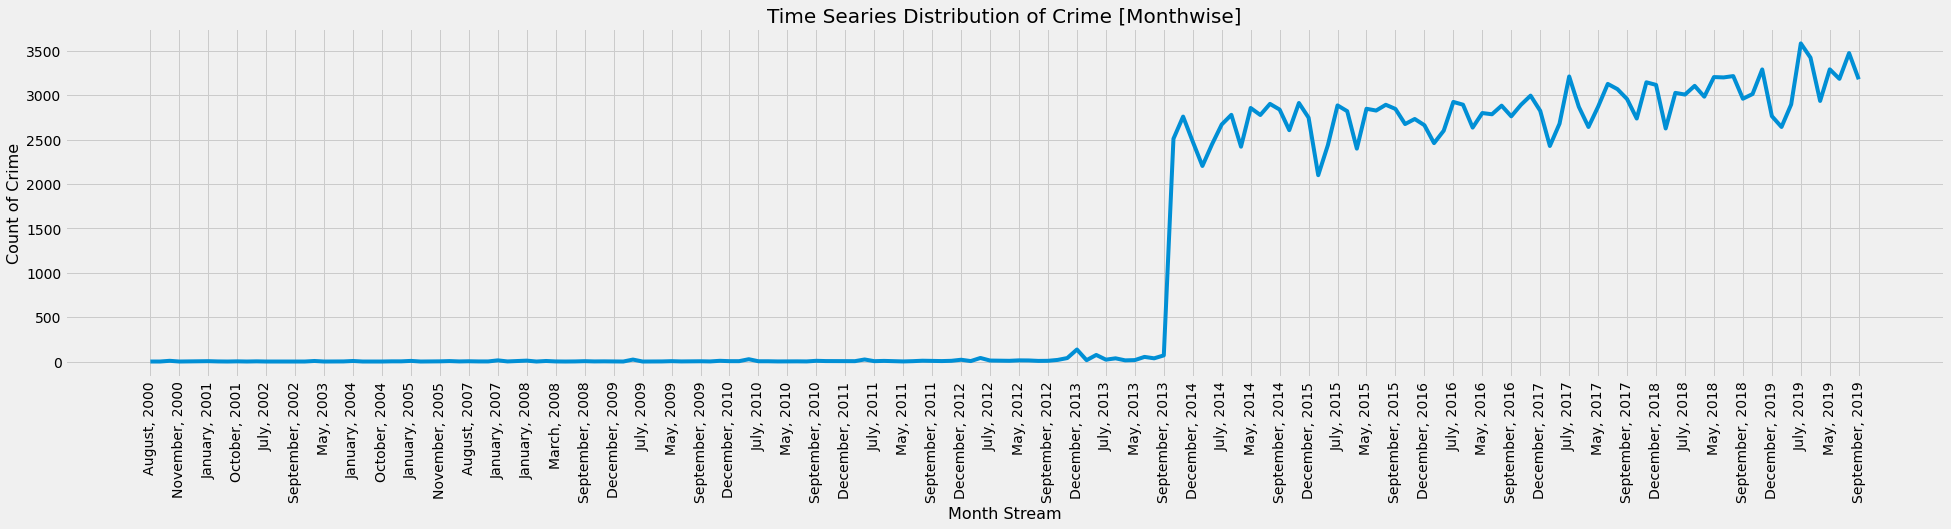

In [20]:
mci_distribution = df.groupby(['occurrenceyear','occurrencemonth'],as_index=False).agg({'count':'sum'})
mci_distribution['occurrenceyear']= mci_distribution['occurrenceyear'].astype('int').astype('str')
mci_distribution['monthYear']= mci_distribution['occurrencemonth'] +', '+ mci_distribution['occurrenceyear']

plt.grid('on')
plt.plot(mci_distribution['monthYear'], mci_distribution['count'])
plt.xlabel('Month Stream')
plt.ylabel('Count of Crime')
plt.title('Time Searies Distribution of Crime [Monthwise]')
plt.xticks(np.arange(0, mci_distribution['monthYear'].shape[0], 3), rotation=90)
plt.show()

In [21]:
occuranceDateVsMciCount= df.groupby(['occurrenceOnlyDate','MCI'],as_index=False).agg({'count':'sum'})
trimmedOccuranceDateVsMciCount= occuranceDateVsMciCount[occuranceDateVsMciCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]

In [22]:
# occuranceDateCount= df.groupby(['occurrenceOnlyDate'],as_index=False).agg({'count':'sum'})
occuranceDateCount= df.groupby('occurrenceOnlyDate')['count'].sum().reset_index()
trimmedOccuranceDateCount= occuranceDateCount[occuranceDateCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]
trimmedOccuranceDateCount['occurrenceOnlyDate']= pd.to_datetime(trimmedOccuranceDateCount.occurrenceOnlyDate)
trimmedOccuranceDateCount.set_index('occurrenceOnlyDate', inplace=True)

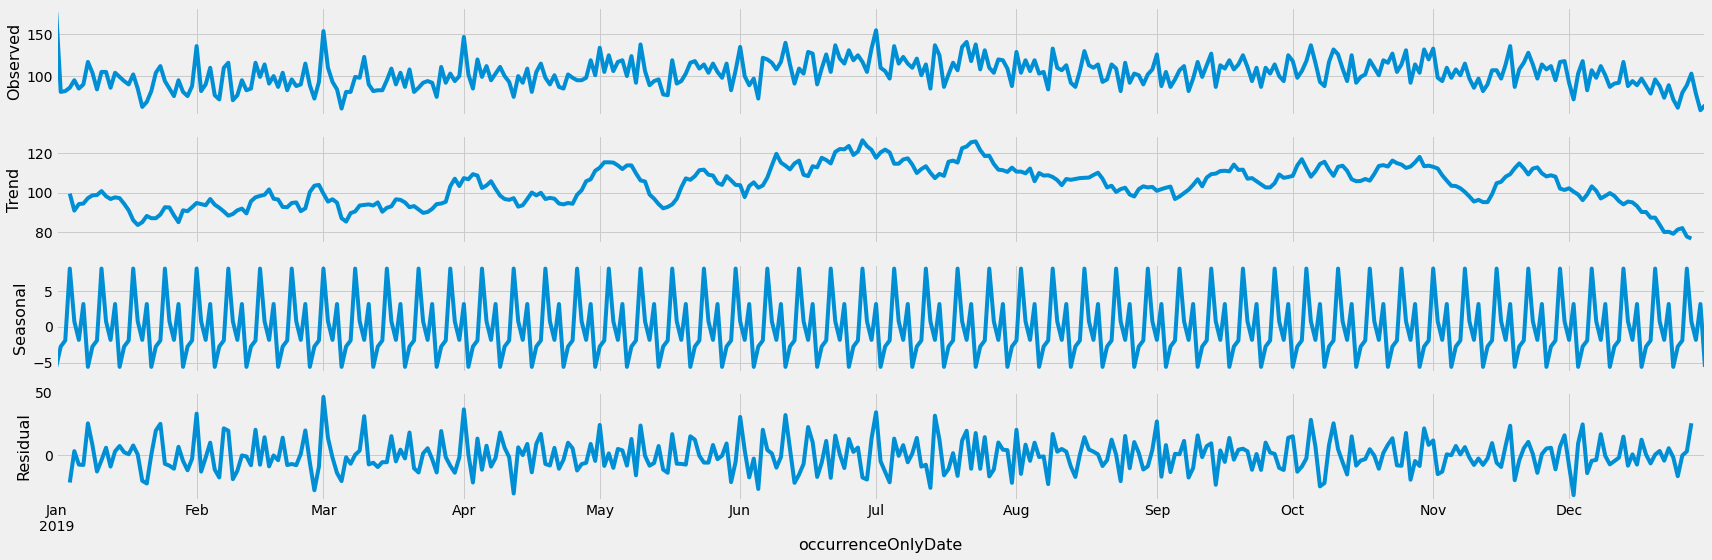

In [23]:
decomposition= sm.tsa.seasonal_decompose(trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')], model='additive')

plt.rcParams['figure.figsize'] = 24, 8
decomposition.plot()

plt.show()

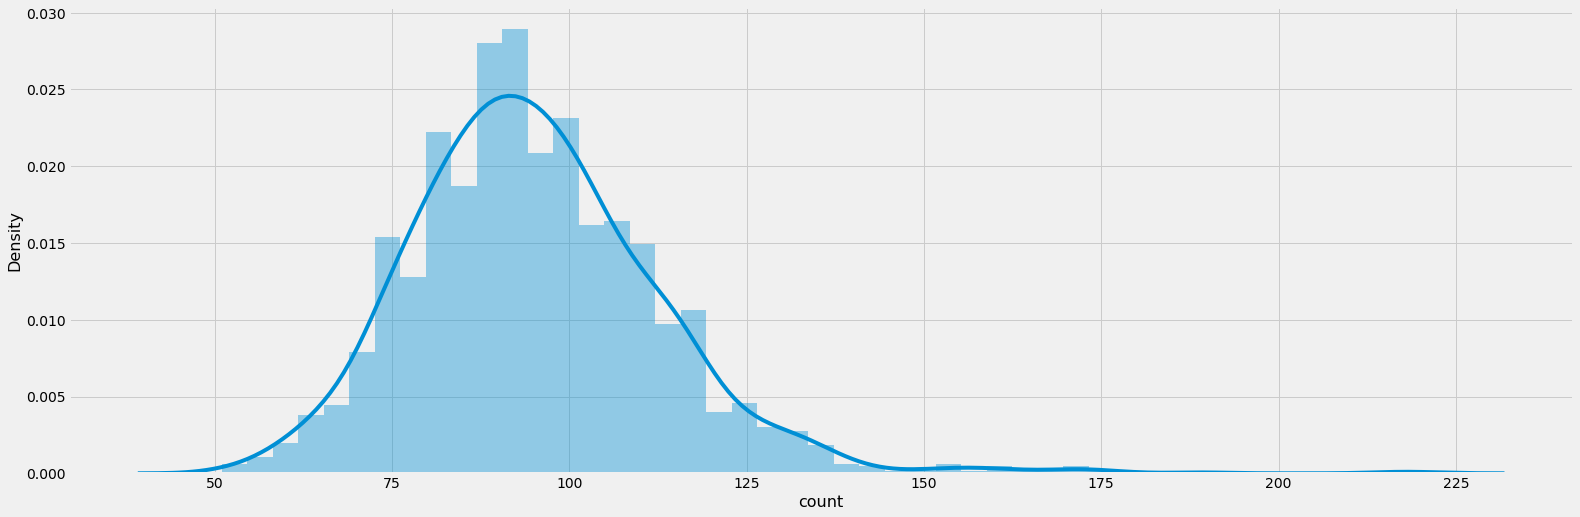

In [24]:
sns.distplot(trimmedOccuranceDateCount['count'])
plt.show()

In [25]:
trainData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index < pd.to_datetime('2018-12-31')]
testData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')]

y= trimmedOccuranceDateCount['count'].resample('MS').mean()

In [26]:
## **SARIMA** Time Series Forcasting

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

resultDict= dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod= sm.tsa.statespace.SARIMAX(trainData, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            resultDict['ARIMA{}x{}12'.format(param, param_seasonal)]= results.aic
        except:
            continue

minIndexARIMA= list(resultDict.keys())[(list(resultDict.values()).index(min(resultDict.values())))]
print('MIN INDEX: {}'.format(minIndexARIMA))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17416.56741969255
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15834.289307207722
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13080.942401398417
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12173.566337827879
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13114.613248496138
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12239.617844055278
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12664.253674635018
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12173.585890976676
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15918.05394188398
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14988.462581171843
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13056.04538202997
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12125.886753981604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13093.041693103562
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12192.606354550739
ARIMA(0, 0, 1)x(1, 1, 

In [42]:
crimeforecast=results.forecast(steps=365)[0]
testData

,count
occurrenceOnlyDate,
2019-01-01,177
2019-01-02,81
2019-01-03,82
2019-01-04,86
2019-01-05,95
...,...
2019-12-27,89
2019-12-28,103
2019-12-29,79


In [35]:
SARIMAXmodel= sm.tsa.statespace.SARIMAX(trainData, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
SARIMAXresults= SARIMAXmodel.fit()
print(SARIMAXresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0994      0.025      3.964      0.000       0.050       0.149
ma.L1         -1.0365      0.008   -136.455      0.000      -1.051      -1.022
ma.S.L12      -1.0000     33.167     -0.030      0.976     -66.006      64.006
sigma2       234.1510   7766.279      0.030      0.976    -1.5e+04    1.55e+04


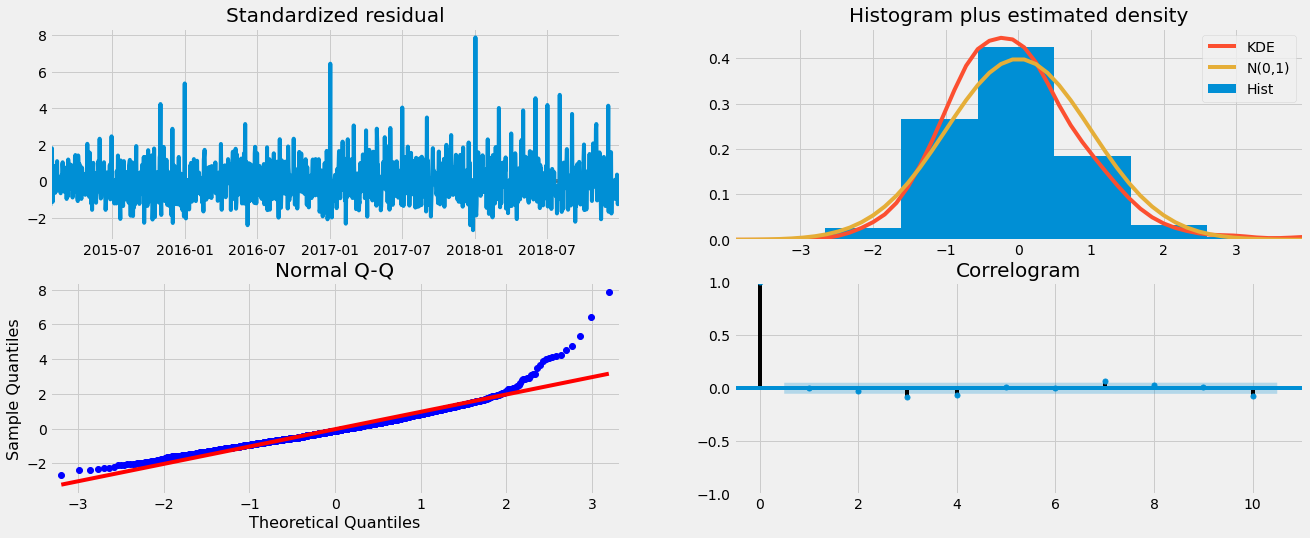

In [43]:
SARIMAXresults.plot_diagnostics(figsize=(20, 8))
plt.show()

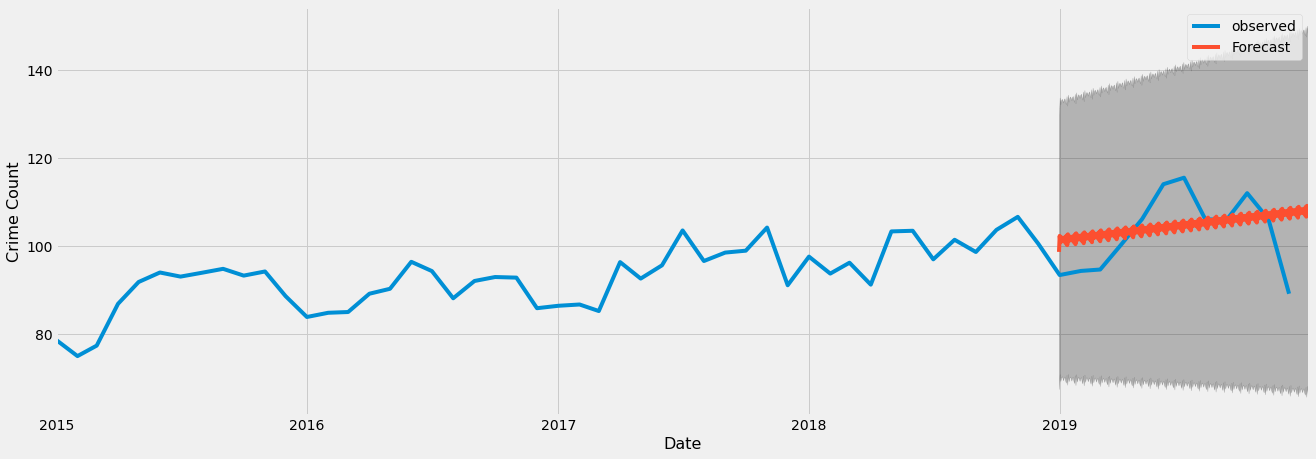

In [44]:
pred_uc= SARIMAXresults.get_forecast(steps=365)
pred_ci= pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [45]:
testData['predValues']= pred_uc.predicted_mean.astype('int')

testData['lowerCount']= pred_ci[pred_ci.index >= testData.index.min()]['lower count']
testData['upperCount']= pred_ci[pred_ci.index >= testData.index.min()]['upper count']

mse= round(((testData['count'] - testData['predValues'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['upperCount'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['lowerCount'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(testData.head())

Mean Square Error: 285.83
Root Mean Square Error: 16.91
Mean Square Error with Upper Envelop: 1707.73
Root Mean Square Error with Upper Envelop: 41.32
Mean Square Error with Lower Envelop: 1503.55
Root Mean Square Error with Lower Envelop: 38.78

                    count  predValues  lowerCount  upperCount
occurrenceOnlyDate                                           
2019-01-01            177       102.0   70.838783  133.831624
2019-01-02             81       100.0   69.308981  132.374860
2019-01-03             82       101.0   70.064415  133.179834
2019-01-04             86       101.0   70.381296  133.544138
2019-01-05             95       101.0   70.029399  133.238222


In [46]:
## **Prophet** Time Series


In [47]:
trimmedOccuranceDateCountProphetFit= trainData.reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
prophet_model= Prophet(daily_seasonality=True)
prophet_model.fit(trimmedOccuranceDateCountProphetFit)

In [48]:
prophetForecast= prophet_model.make_future_dataframe(periods=365)
prophetForecast= prophet_model.predict(prophetForecast)

<Figure size 1296x432 with 0 Axes>

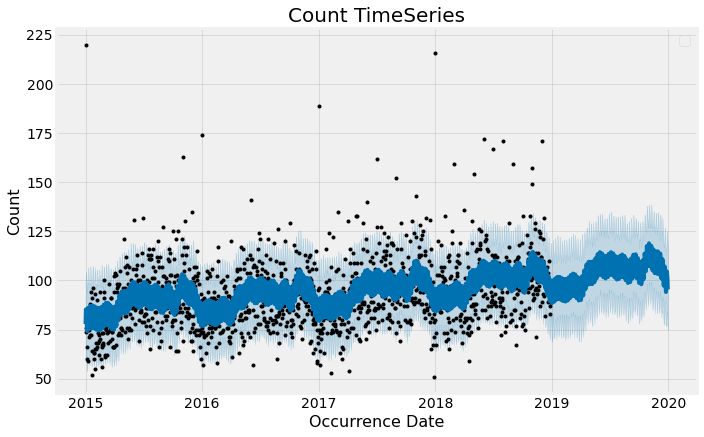

In [49]:
plt.figure(figsize=(18, 6))
prophet_model.plot(prophetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.legend()
plt.title('Count TimeSeries');

In [50]:
prophetForcast_yhat= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
prophetForcast_trend= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['trend', 'trend_lower', 'trend_upper']]
for _ in tqdm(prophetForcast_yhat.columns):
  prophetForcast_yhat[_]= prophetForcast_yhat[_].astype('int')
for _ in tqdm(prophetForcast_trend.columns):
  prophetForcast_trend[_]= prophetForcast_trend[_].astype('int')

100%|██████████| 3/3 [00:00<00:00, 890.64it/s]


In [51]:
mse= round(((testData['count'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete yHat Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_yhat.head())

Prophet Complete yHat Data Error Analysis

Mean Square Error: 248.27
Root Mean Square Error: 15.76
Mean Square Error with Upper Envelop: 622.6
Root Mean Square Error with Upper Envelop: 24.95
Mean Square Error with Lower Envelop: 653.93
Root Mean Square Error with Lower Envelop: 25.57

            yhat  yhat_lower  yhat_upper
ds                                      
2019-01-01    88          68         107
2019-01-02    91          70         110
2019-01-03    92          72         112
2019-01-04    99          82         120
2019-01-05    98          77         117


In [ ]:
mse= round(((testData['predValues'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['upperCount'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['lowerCount'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis

Mean Square Error: 34.76
Root Mean Square Error: 5.9
Mean Square Error with Upper Envelop: 369.44
Root Mean Square Error with Upper Envelop: 19.22
Mean Square Error with Lower Envelop: 264.27
Root Mean Square Error with Lower Envelop: 16.26


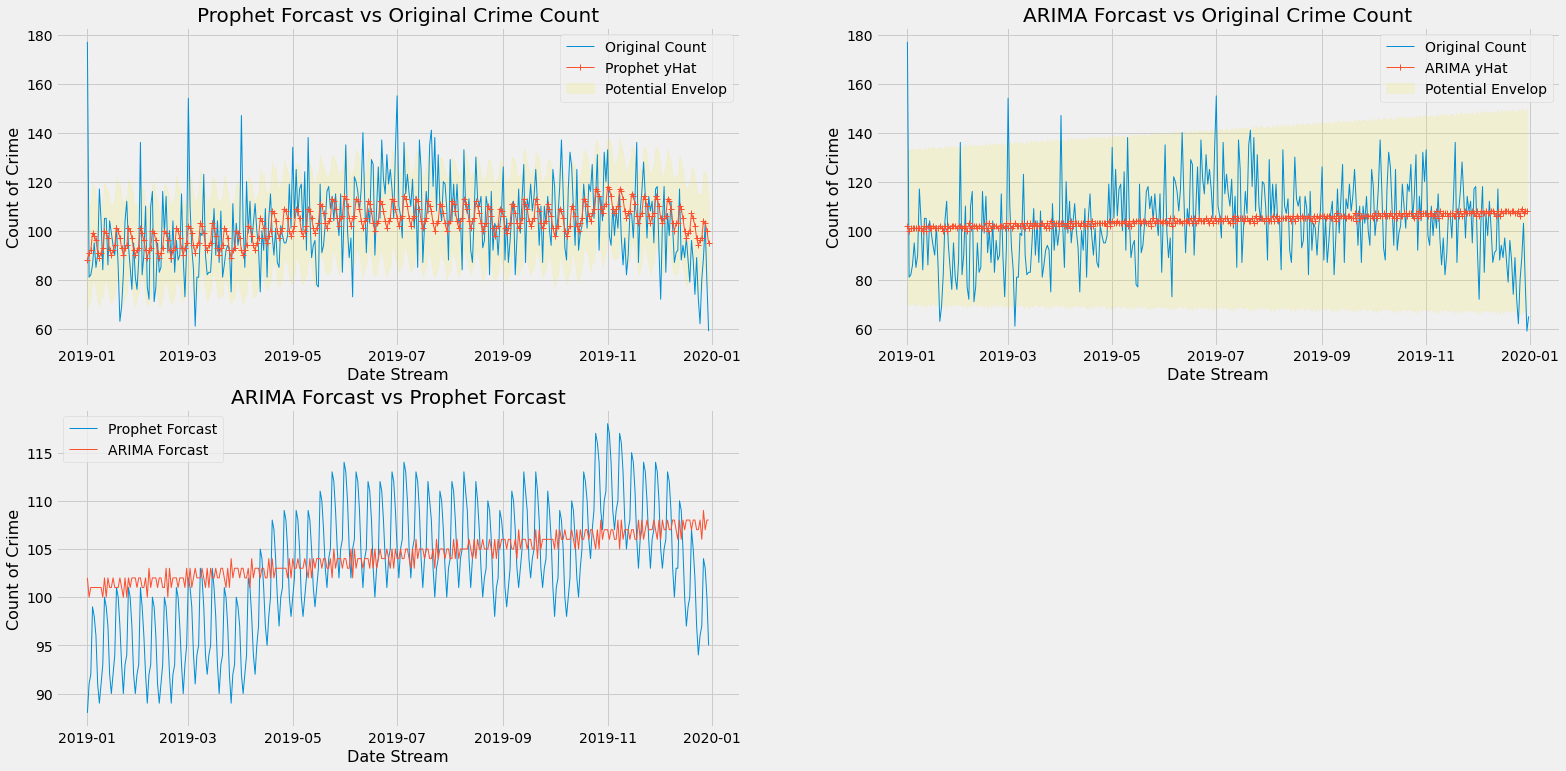

In [ ]:
plt.rcParams['figure.figsize']= 24, 12

plt.subplot(221)
plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count')
plt.plot(prophetForcast_yhat.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1, marker='+')
plt.fill_between(prophetForcast_yhat.index, prophetForcast_yhat['yhat_upper'], prophetForcast_yhat['yhat_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])


plt.subplot(222)
plt.grid('on')
plt.title('ARIMA Forcast vs Original Crime Count')
plt.plot(testData.index, testData['count'], lw=1)
plt.plot(testData.index, testData['predValues'], lw=1, marker='+')
plt.fill_between(testData.index, testData['upperCount'], testData['lowerCount'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'ARIMA yHat', 'Potential Envelop'])

plt.subplot(223)
plt.grid('on')
plt.title('ARIMA Forcast vs Prophet Forcast')
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1)
plt.plot(testData.index[:-1], testData['predValues'][:-1], lw=1)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Prophet Forcast', 'ARIMA Forcast'])

plt.show()

In [ ]:
print('Different Major Crime Indicators', end='\n\n')
for i, _ in enumerate(np.unique(df.MCI)):
  print('{}. {}'.format(i, _))

  mciDifferedResult= pd.DataFrame()

Different Major Crime Indicators

0. Assault
1. Auto Theft
2. Break and Enter
3. Robbery
4. Theft Over


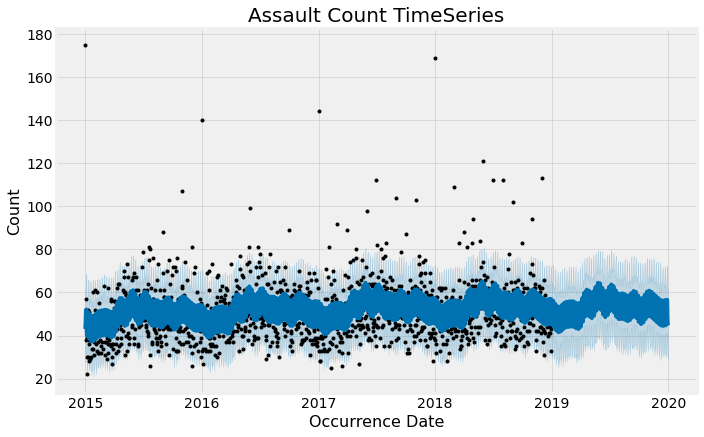

In [ ]:
assaultTimewiseData= df[df.MCI == 'Assault'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
assaultTimewiseData= assaultTimewiseData[assaultTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  assaultTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

assaultProphetModel= Prophet(daily_seasonality=True).fit(assaultTimewiseData[assaultTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
assaultProphetForecast= assaultProphetModel.make_future_dataframe(periods=365)
assaultProphetForecast= assaultProphetModel.predict(assaultProphetForecast)

assaultProphetModel.plot(assaultProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Assault Count TimeSeries');

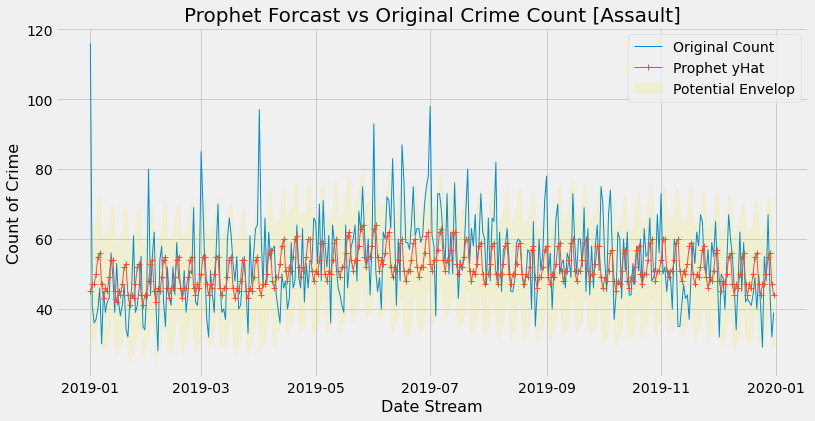

In [ ]:
comparableData= assaultTimewiseData[assaultTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= assaultProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= assaultProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= assaultProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['Assault']= comparableData.yhat
mciDifferedResult['lower']= comparableData.yhatLower
mciDifferedResult['upper']= comparableData.yhatUpper

plt.rcParams['figure.figsize']= 12,6

plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

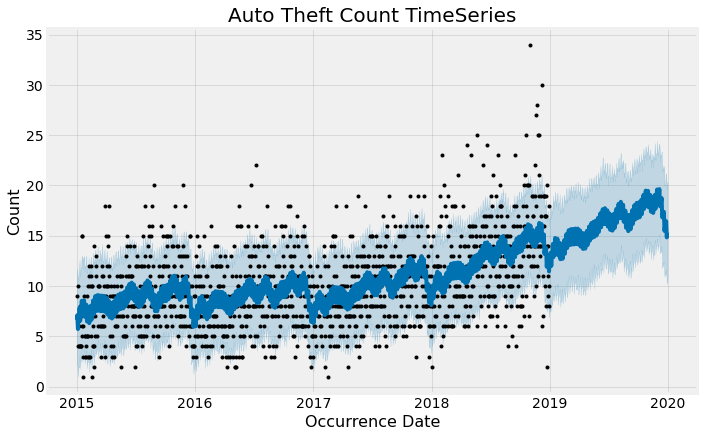

In [ ]:
autoTheftTimewiseData= df[df.MCI == 'Auto Theft'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
autoTheftTimewiseData= autoTheftTimewiseData[autoTheftTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  autoTheftTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

autoTheftProphetModel= Prophet(daily_seasonality=True).fit(autoTheftTimewiseData[autoTheftTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
autoTheftProphetForecast= autoTheftProphetModel.make_future_dataframe(periods=365)
autoTheftProphetForecast= autoTheftProphetModel.predict(autoTheftProphetForecast)


autoTheftProphetModel.plot(autoTheftProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Auto Theft Count TimeSeries');

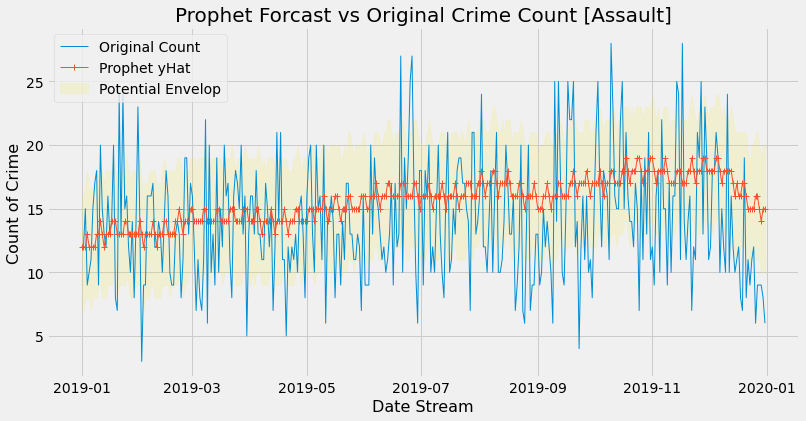

In [ ]:
comparableData= autoTheftTimewiseData[autoTheftTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= autoTheftProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= autoTheftProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= autoTheftProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['AutoTheft']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()